# Load Data

In [8]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

In [10]:
train_df = pd.read_csv('datasets/titanic/train.csv')
test_df = pd.read_csv('datasets/titanic/test.csv')
combine = [train_df, test_df]
# combine is used to ensure whatever preprocessing is done on training data
# is also done on test data

# NOTE! When we change train_df or test_df the objects in combine 
# will also change (combine is only a pointer to the objects)

# Explore Data

In [11]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


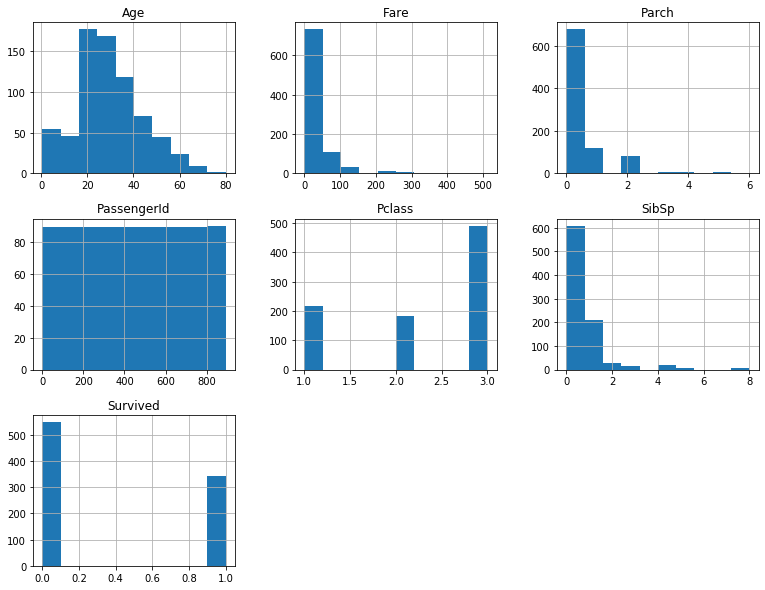

In [13]:
train_df.hist(figsize=(13,10))
plt.show()

In [21]:
target_count = train_df['Survived'].value_counts()
target_count

0    549
1    342
Name: Survived, dtype: int64

In [22]:
target_count[0]/(sum(target_count)) 

0.6161616161616161

In [23]:
print("Shapes Before: (train) (test) = ", \
      train_df.shape, test_df.shape)

Shapes Before: (train) (test) =  (891, 12) (418, 11)


In [25]:
# Drop columns 'Ticket', 'Cabin', need to do it for both test and training

train_df = train_df.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("Shapes After: (train) (test) =", train_df.shape, test_df.shape)

Shapes After: (train) (test) = (891, 9) (418, 9)


In [26]:
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


# Feature Engineering

In [27]:
# List example titles in Name column

train_df.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'
# if you want to match Titles or Names with any other expression
# refer to this tutorial on regex in python:
# https://www.tutorialspoint.com/python/python_reg_expressions.htm

# Create column called Title

for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [36]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [37]:
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [38]:
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Rare'

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') #Mademoiselle
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') #Madame

In [39]:
train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


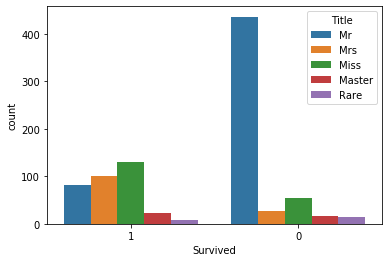

In [41]:
sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

make titles into dummies

In [49]:
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    print(binary_encoded)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

     Master  Miss  Mr  Mrs  Rare
0         0     0   1    0     0
1         0     0   0    1     0
2         0     1   0    0     0
3         0     0   0    1     0
4         0     0   1    0     0
..      ...   ...  ..  ...   ...
886       0     0   0    0     1
887       0     1   0    0     0
888       0     1   0    0     0
889       0     0   1    0     0
890       0     0   1    0     0

[891 rows x 5 columns]
     Master  Miss  Mr  Mrs  Rare
0         0     0   1    0     0
1         0     0   0    1     0
2         0     0   1    0     0
3         0     0   1    0     0
4         0     0   0    1     0
..      ...   ...  ..  ...   ...
413       0     0   1    0     0
414       0     0   0    0     1
415       0     0   1    0     0
416       0     0   1    0     0
417       1     0   0    0     0

[418 rows x 5 columns]


In [52]:
# Title dummy mapping: Map titles to binary dummy columns

for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    print(type(binary_encoded))
    newcols = binary_encoded.columns
    print(newcols)
    dataset[newcols] = binary_encoded

<class 'pandas.core.frame.DataFrame'>
Index(['Master', 'Miss', 'Mr', 'Mrs', 'Rare'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index(['Master', 'Miss', 'Mr', 'Mrs', 'Rare'], dtype='object')


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


In [55]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].replace(["male","female"], [0,1])

In [57]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


In [58]:
# create empty array  for later use

guess_ages = np.zeros((2,3),dtype=int) 
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [66]:
# Fill the NA's for the Age columns
# with "qualified guesses"

for idx,dataset in enumerate(combine):  
    # method adds a counter to an iterable and returns it in a form of enumerate object.     
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            print((dataset['Sex'] == i)&(dataset['Pclass'] == j+1))
            guess_df = dataset[(dataset['Sex'] == i)&(dataset['Pclass'] == j+1)]['Age'].dropna()
            print(guess_df)

            # Extract the median age for this group
            # (less sensitive) to outliers
            age_guess = guess_df.median()
          
            # Convert random age float to int
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done! \n\n\n')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889     True
890    False
Length: 891, dtype: bool
6      54
23     28
27     19
30     40
34     28
       ..
839    40
857    51
867    31
872    33
889    26
Name: Age, Length: 122, dtype: int64
0      False
1      False
2      False
3      False
4      False
       ...  
886     True
887    False
888    False
889    False
890    False
Length: 891, dtype: bool
17     30
20     35
21     34
33     66
70     32
       ..
848    28
861    21
864    24
883    28
886    27
Name: Age, Length: 108, dtype: int64
0       True
1      False
2      False
3      False
4       True
       ...  
886    False
887    False
888    False
889    False
890     True
Length: 891, dtype: bool
0      22
4      35
5      25
7       2
12     20
       ..
877    19
878    25
881    33
884    25
890    3

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S,Mr,0,0,1,0,0
